# FROG TESTING

heres where all the random testing is gonna go for frog stuff for now.

in the future you will make seperate juypter lab files for different things. but now just seperate diff ideas with a markdown cell


In [1]:
import numpy as np
import cv2 as cv #opencv - for reading in images
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
%matplotlib inline

In [2]:
# fignum = 1
# chose_f = c_trc_f[201]*h2th
# chose_d = c_trc_d[527]*s2fs
# b_leg = '$\\tau$={d: .1f}'.format(d=chose_d)
# c_leg = '$\omega$={c:.3f} THz'.format(c=chose_f)
# figtitle = 'Fig {}:'.format(fignum) + ' Measured FROG Trace'
# fig = plt.figure(figsize=(6,6));
# gs = fig.add_gridspec(2,2,width_ratios=(7,2),height_ratios=(2,7),left=.1,right=.9,bottom=.1,top=.9,wspace=.1,hspace=.15)
# ax = fig.add_subplot(gs[1,0])
# ax_x = fig.add_subplot(gs[0,0],sharex=ax) # constant delay
# ax_y = fig.add_subplot(gs[1,1],sharey=ax) # constant freq, swap x vs y position for this one
# ax_x.tick_params(axis='x',labelbottom=False)
# ax_y.tick_params(axis='y',labelleft=False)
# ax.pcolormesh(c_trc_f*h2th,c_trc_d*s2fs,c_pic,cmap='hot')
# ax.axvline(c_trc_f[201]*1.e-15,c='w',ls='--');
# ax.axhline(c_trc_d[527]*1.e15,c='w',ls='--');
# ax.set_xlabel('Frequency [THz]');
# ax.set_ylabel('Delay [fs]');
# ax_x.plot(c_trc_f*h2th,c_pic[527,:],c='k',label=b_leg)
# ax_x.legend()
# ax_x.set_ylabel('I [cts]')
# ax_y.plot(c_pic[:,201],c_trc_d*s2fs,c='k',label=c_leg)
# ax_y.legend()
# ax_y.set_xlabel('I [cts]')
# fig.suptitle(figtitle);
# ax.set_title('(A)',loc='left',pad=6.)
# ax.set_title('$I_{FROG}(\omega_i,\\tau_j)$')
# ax_y.set_title('(C)',loc='left')
# ax_x.set_title('(B)',loc='left')
# plt.show();
# fig.savefig('test.png',dpi=300)

In [3]:
# constants
c = 2.99e8 # speed of light in vac [m/s]
# factors for plotting, b/c im working in m and sec
h2th = 1.e-15 # Hz to THz
m2nm = 1.e9 # m to nm
s2fs = 1.e15 # s to fs

### Image processing

start by taking the data from the spectrograph and turning it into the standard plots that are the FROG inputs

what functions do we want:

     - read in spectrograph and calibration files, then output the processed trace, and the processed I vs delay and S vs wvl/freq plots
     
         - process meaning any changes to the temporal or spectral spacing to make frog input easier, so making trace matrix NxN, or centering the spectral data on the carrier freq for FFT stuff
         
         - would want user input for amount of processing done (little for basic frog, but specific stuff for GP or others)
     
     - read in spectrograph and calibration files then save processed image as a picture and NxM matrix, and the processed temporal and spectral intensities 

current programs I need:

    - read in raw pic and calibration data and outputs raw pic, and raw trace with delay, freq, and wvl arrays 
    - read in raw trace, delay, and freq, input crop, optional delay and freq spacing, output the cropped graph with cropped delay and freq arrays
    - read in cropped trace, delay and freq, input freq and delay, output 3 nice graphs at specified freq and delay
        - might also want to save, output, etc the center freq for fft stuff
    - read in cropped trace, delay and freq, input new pic dimensions, output 3 graphs and 3 adjusted arrays
        - will want to have a contour plot on hand for next part
    - read in crop+adj trace, delay, and freq, input boxcar size and any specifications about how/where to avg, output 3 graphs and crop+adj+processed (CAP) trace 
    - read CAP trace and CA delay/freq arrays and save data as text files

In [4]:
# start with reading in the image
# assuming function will stay in parent folder of all data folders (same as liam)
folder = './Raw PHAROS/' 
fname = 'raw_pharos.tif'
# function input: file name (including path)
raw_pic = cv.imread(folder+fname,cv.IMREAD_UNCHANGED) # -1 flag is to leave unchanged
# the orientation of the matrix vs the picture is flipped, does it need to be flipped back??
# confirm that spectrogram is delays(x) and wvl(y) 
# b/c that is opposite convention of trebino's frog, but does make sense in contxt of image
# find and read documentation on spectrometer, princeton optics isoplane 160 
# also need detector specs too

In [61]:
# next step is to take in the calibration data and turn it into delay and wvl
# function input: some sort of data structure that holds the calibration data (dict or maybe just a txt file)
# data needed: calibration pix wvl (wvl of a horz pix) [pix] / delay/vert pix [s/pix] / wvl/horz pix [m/pix]
# SWITCHED FROM USING 'calibration data.txt' (cuz it was weird) to 'raw PHAROS Autocorrelation spectrum' it atleast has same wvl range
# ^ but doesnt have even spaced stuff so just taking an avg of the spacings
# as far as i know, delays just have 0 at the middle
cali_wvl = 638.453e-9 # [m]
cali_pix = 1025 # [pix]
dpp = .1e-15 # delay-per-pixel [s/pix]
wpp = .414e-9 # wvl-per-pixel [m/pix]

# now want to be able to make traces have delay vs wvl and freq rather than pixels
# DONT assume the raw pic is sym
# need if for if vert/horz pix size is even/odd (currently have even setup)
trc_d = np.linspace(-raw_pic.shape[0]/2.,raw_pic.shape[0]/2.,raw_pic.shape[0])*dpp # trace delay array [s]
leftw = cali_wvl - cali_pix*wpp
rightw = cali_wvl + (raw_pic.shape[1]-cali_pix)*wpp
trc_w = np.linspace(leftw,rightw,raw_pic.shape[1]) # trace wvl array [m]
trc_f = np.linspace(c/leftw,c/rightw,raw_pic.shape[1]) # trace freq array [Hz]
# should the center of the pulse be at 0 delay????
# regardless of having nonsense will want to crop data

# function input: times and wvls you would like cropped from trace, want bot left and top right, min/max delay + wvl, dont assume cropping makes sym
# crop input should be min and max of wvl and delay and are both array: crop_wvl,crop_delay
# should be 2 funct, one crops and shows pics, can turn changing trace into NxN on/off
#  ^ the final that just saves requires the changing of trace dimensions
cwvl = np.array([550.,750.])*1.e-9 # wvl to keep in picture [m]
cdelay = np.array([-75.,25])*1.e-15 # delay to keep in pic [s]
cfreq = c/cwvl
# # create cropped trace arrays
cf = (trc_f>=cfreq[1])&(trc_f<=cfreq[0])
ct = (trc_d>=cdelay[0])&(trc_d<=cdelay[1])
c_trc_d = trc_d[ct]
# c_trc_w = trc_w[cw]
c_trc_f = trc_f[cf]
c_pic = np.zeros((len(c_trc_d),len(c_trc_f)))
# c_pic = raw_pic[ct,:]
# c_pic = raw_pic[:,cw]
# c_pic = raw_pic[ct,:]
# c_pic = c_pic[:,cw]
# # is there any adjustments needed to make for the actual intensity values (liam makes the min value 0)????

In [62]:
c_pic.shape

(1000, 266)

In [67]:
crp_ind_d = np.array([find_int(trc_d,cdelay[i]) for i in range(2)])
crp_ind_f = np.array([find_int(trc_f,cfreq[i]) for i in range(2)])
# preallocate arrays
cd_arr = np.zeros(np.diff(crp_ind_d))
cf_arr = np.zeros(np.diff(crp_ind_f))
c_trace = np.zeros((len(cd_arr),len(cf_arr)))
print(crp_ind_d,crp_ind_f)
cd_arr = trc_d[crp_ind_d[0]:crp_ind_d[1]]
cf_arr = trc_f[crp_ind_f[0]:crp_ind_f[1]]
c_trace = raw_pic[crp_ind_d[0]:crp_ind_d[1],crp_ind_f[0]:crp_ind_f[1]]
print(c_trace.shape)

[ 273 1273] [1565 1831]
(1000, 266)


In [26]:
# testing noise reduction algorithms
trc_f

array([1.39652410e+15, 1.39597942e+15, 1.39543473e+15, ...,
       2.82640257e+14, 2.82095570e+14, 2.81550884e+14])

In [7]:
# next would be to do any sort of processing
# currently all i can tell is adjusting spacing, cropping, removing background so that all next
# it seems like unless i do basic frog, making the trace NxN is important
# removing bkgnd is important in basic frog because its sensitive to fall apart at noise, but how to remove?
# maybe contour plot could help remove or determine what to remove
# trebino has plenty to say about processing as well
# current ideas: 2-d boxcar avg
# 2d boxcar: seperate NxN trace into smaller MxM boxcars of trace, take avg and std,
# ^ box with max and surounding boxes remain unchanged, avg the avg of all other boxes and that is the noise, subt num from trace
# ^^ use contour to find what boxes to use

boxcar is a good idea, however if you use the I($\omega$) and I($\tau$) plots as a ref you can create a mask of the array where the signal is and then avg or median filter everywhere else

https://stackoverflow.com/questions/16856788/slice-2d-array-into-smaller-2d-arrays

https://towardsdatascience.com/image-filters-in-python-26ee938e57d2#:~:text=1.-,Mean%20Filter,the%20edges%20of%20the%20image.

^ talking about image filtering

In [6]:
def find_int(arr,val):
    'finds the index of arr (Nx1) that matches closest to val, note values in arrays in questions are in m,s, etc'
    # will want an assert to ensure that val is within arr
    within = ((val<arr[0])&(val>arr[-1]))|((val>arr[0])&(val<arr[-1]))
    assert(within)
    dx = arr[1] - arr[0]
    dist = val - arr[0]
    ind = int(dist//dx)
    return ind

In [10]:
def get_med(trace,d_arr,f_arr,bnd_val):
    'median filter that takes in the stuff above and returns the median, using within a function for mem allocation purposes'
    # do index array for each guy
    bnd_ind_d = np.array([find_int(trc_d,bnd_val[0]),find_int(trc_d,bnd_val[1])])
    bnd_ind_f = np.array([find_int(trc_f,bnd_val[2]),find_int(trc_f,bnd_val[3])]) # indices of interest
    # do an if to ensre that both guys are in order
    if (bnd_ind_d[0]>bnd_ind_d[1]):
        bnd_ind_d = bnd_ind_d[::-1]
    if (bnd_ind_f[0]>bnd_ind_f[1]):
        bnd_ind_f = bnd_ind_f[::-1]
    # fun fact, python passes objects into the functions so if you pass in a mutable object defined globally into the function and modify it, (as long as its not a redefinition)
    # it will be keep that change, however this only works for mutable objects :( 
    # this means imma have to figure out some other way to do this silly thing
    zone_med = np.zeros(4,dtype=int)
    zone_med[:2] = np.array([np.median(np.hsplit(raw_pic,bnd_ind_f)[::2][i]) for i in range(2)],dtype=int)
    zone_med[2:] = np.array([np.median(np.vsplit(raw_pic,bnd_ind_d)[::2][i]) for i in range(2)],dtype=int)
    # np.splits returns a view of a list of arrays so thats why the wacky indexing and list comprehension are required
    # also this only works for removing a block but np.split will be useful for the boxcar avg
    med = int(np.median(zone_med))
    return med

In [34]:
# def med_filter(trace,d_arr,f_arr,bnd_val):
# #     https://numpy.org/doc/stable/reference/arrays.scalars.html#numpy.uintc
#     'actual filter funct, ensures no number overflow'
#     med = get_med(trace,d_arr,f_arr,bnd_val)
#     print(med) # only need for diag purposes, delete later
#     float_arr = trace.astype(float,copy=False) # dont create a copy, because we will return it to int at the end

71


In [21]:
bnd_val = (-60./s2fs,20./s2fs,.8/h2th,.9/h2th) # the 4 values that block off the signal in the frog trace, ([s],[s],[Hz],[Hz]), low then high
med = get_med(raw_pic,trc_d,trc_f,bnd_val)
print(med)
# testing that not creating a copy will work, will want to restart kernal after this to have a fresh raw_pic
raw_pic = raw_pic.astype(float,copy=False)
print(raw_pic)
raw_pic -= med
# put all elements < 0 -> = 0
raw_pic[raw_pic<0] = 0.
assert(np.all(raw_pic>=0))
raw_pic = raw_pic.astype('H',copy=False) # 'H' = uint16, which is og dtype
print(raw_pic)

71
[[90. 92. 88. ... 80. 82. 83.]
 [81. 92. 85. ... 79. 81. 78.]
 [86. 84. 85. ... 78. 76. 87.]
 ...
 [66. 73. 76. ... 77. 73. 71.]
 [74. 76. 75. ... 72. 67. 71.]
 [78. 74. 73. ... 84. 80. 76.]]
[[19 21 17 ...  9 11 12]
 [10 21 14 ...  8 10  7]
 [15 13 14 ...  7  5 16]
 ...
 [ 0  2  5 ...  6  2  0]
 [ 3  5  4 ...  1  0  0]
 [ 7  3  2 ... 13  9  5]]


In [25]:
# ref to what i did for get_med function, doesnt run repeatibly because it number overflows b/c issa 16bit int, think gandhi in civ
# bnd_val = (-60./s2fs,20./s2fs,.8/h2th,.9/h2th) # the 4 values that block off the signal in the frog trace, ([s],[s],[Hz],[Hz]), low then high
# # do index array for each guy
# bnd_ind_d = np.array([find_int(trc_d,bnd_val[0]),find_int(trc_d,bnd_val[1])])
# bnd_ind_f = np.array([find_int(trc_f,bnd_val[2]),find_int(trc_f,bnd_val[3])]) # indices of interest
# print(bnd_ind_d,bnd_ind_f)
# # do an if to ensre that both guys are in order
# if (bnd_ind_d[0]>bnd_ind_d[1]):
#     bnd_ind_d = bnd_ind_d[::-1]
# if (bnd_ind_f[0]>bnd_ind_f[1]):
#     bnd_ind_f = bnd_ind_f[::-1]
# print(bnd_ind_d,bnd_ind_f)
# # create mask, not very memory efficent right now, need to think about that, or atleast delete the mask
# # if we make it a function then we can destroy 
# pic_mask = raw_pic
# pic_mask[bnd_ind_d[0]:bnd_ind_d[1],bnd_ind_f[0]:bnd_ind_f[1]] = 0
# pic_mask = pic_mask[pic_mask!=0]
# assert(pic_mask.all()) #double check you got rid of the part that was signal
# med = int(np.median(pic_mask)) # this is the background noise
# print(med,np.mean(pic_mask))
# del pic_mask # as of rn this is the best way to preserve mem i know how
# raw_pic = raw_pic - med
# raw_pic[raw_pic<0] = 0 # no neg values
# assert(np.all(raw_pic>=0)) # ensure there are no neg values

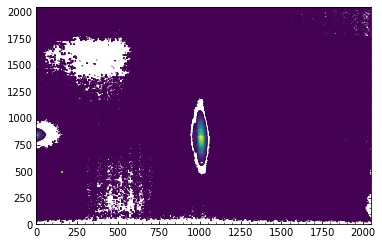

In [22]:
plt.contour(raw_pic,levels=40);
# plt.axhline(s2fs*trc_d[len(trc_d)//num_box]);
# plt.axhline(s2fs*trc_d[2*len(trc_d)//num_box]);

In [23]:
# finally would be to save the plots and data

In [24]:
c_pic.shape

(1000, 483)

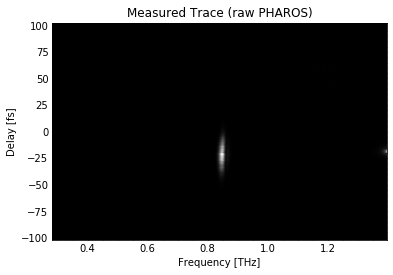

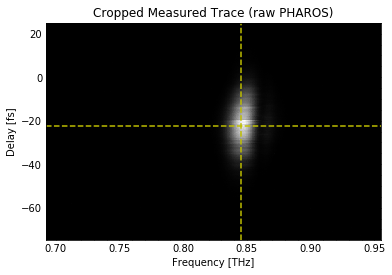

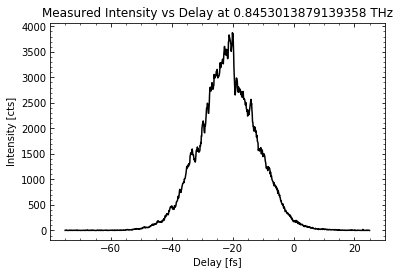

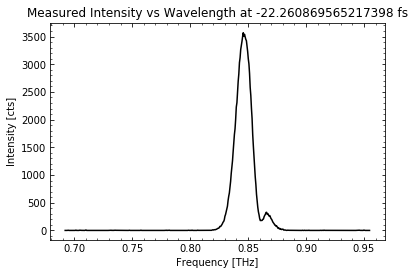

In [28]:
# graphs we may want to include
# include horz/vert line to show where the I vs delay or I vs freq plot comes from
# raw pic
plt.figure();
plt.pcolormesh(trc_f*1.e-15,trc_d*1.e15,raw_pic,cmap='gray');
plt.xlabel('Frequency [THz]');
plt.ylabel('Delay [fs]');
plt.title('Measured Trace (raw PHAROS)');
# cropped raw pic
plt.figure();
plt.pcolormesh(c_trc_f*1.e-15,c_trc_d*1.e15,c_pic,cmap='gray');
plt.xlabel('Frequency [THz]');
plt.ylabel('Delay [fs]');
plt.title('Cropped Measured Trace (raw PHAROS)');
# function input: delay and wvl wanted for I vs wvl and I vs delay plots (respectively)
# ^when func produces plots have it be a 2x2 subplot w/ zoomed processed trace in top left, top right and bot left are intensity plots, unzoomed in bot right
plt.axvline(c_trc_f[201]*1.e-15,c='y',ls='--');
plt.axhline(c_trc_d[527]*1.e15,c='y',ls='--');
# intensity vs delay
# will want to swap x and y axis in final version
plt.figure();
plt.plot(c_trc_d*1.e15,c_pic[:,201],c='k');
plt.xlabel('Delay [fs]');
plt.ylabel('Intensity [cts]');
plt.title('Measured Intensity vs Delay at '+str(c_trc_f[201]*1.e-15)+' THz');
# intensity vs freq
plt.figure();
plt.plot(c_trc_f*1.e-15,c_pic[527,:],c='k');
plt.xlabel('Frequency [THz]');
plt.ylabel('Intensity [cts]');
plt.title('Measured Intensity vs Wavelength at '+str(c_trc_d[527]*1.e15)+' fs');

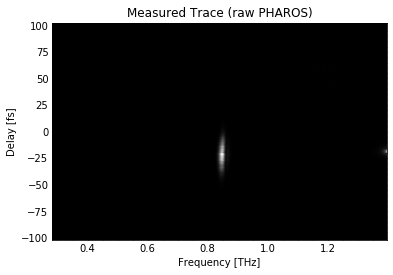

In [26]:
# raw pic
plt.figure();
plt.pcolormesh(trc_f*1.e-15,trc_d*1.e15,raw_pic,cmap='gray');
plt.xlabel('Frequency [THz]');
plt.ylabel('Delay [fs]');
plt.title('Measured Trace (raw PHAROS)');